# <center> AMDA Project </center>
# <center> Analyse des données de cancer du foie </center>

## <center> DARGIER Antoine - DOUILLY Thomas </center>

### <center> 08/05/2023 </center>

# Sommaire

* [0. Installation](#chapter0)
* [1. Introduction](#chapter1)
    * [1.1 Présentation du sujet](#section_1_1)
    * [1.2 Présentation des données et contexte de l'étude](#section_1_2)
* [2. Méthode 2D](#chapter2)
    * [2.1 Pre-processing et analyse en composantes principales](#section_2_1)
    * [2.2 Classification](#section_2_2)
    * [2.3 Principales features](#section_2_3)
* [3. Méthode multivoie](#chapter3)
    * [3.1 Pre-processing et parafac](#section_3_1)
    * [3.2 Principales features](#section_3_2)
    * [3.3 Classification](#section_3_3)
* [4. Gestion des cancers mixtes](#chapter4)
* [5. Conclusion](#chapter5)

# 0. Installation <a class="anchor" id="chapter0"></a>

In [110]:
!pip install tensorly

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
import tensorly as tl
from tensorly.decomposition import parafac

# 1. Introduction <a class="anchor" id="chapter1"></a>

## 1.1 Présentation du sujet <a class="anchor" id="section_1_1"></a>

L'objectif de ce travail est d'analyser le jeu de données fourni par Sébastien Mulé autour de l'analyse en imagerie de cancer de foie. Il s'agit d'un problème de santé publique très important pour plusieus raisons :
  * Incidence en augmentation, que l'on peut corréler avec l'augmentation de l'obésité notamment dans les pays développés ;
  * 3ème cause de décès par cancer dans le monde ;
  * Souvent diagnostiqué à un stade avancé, ce qui laisse le patient sans possibilité de traitement chirurgical.

Ce sujet est intéressant et a du potentiel en étant traité par des méthodes de data science, car le diagnostic est ici possible via imagerie chez les patients à risque (en particulier ceux atteints de cirrhose), ce qui n'est pas toujours le cas pour d'autres cancers où un prélèvement est nécessaire. Ainsi, on peut s'attendre à être capable de diagnostiquer les patients malades à l'aide de modèles de traîtement d'images puis de machine learning.

Ce travail peut être utile car l'analyse de données en imagerie de cancer de foie peut aider à améliorer la détection précoce et le traitement de cette maladie comme dit précédemment. En utilisant des techniques d'analyse d'image, les médecins peuvent détecter les tumeurs hépatiques à un stade précoce, ce qui augmente les chances de guérison et réduit la nécessité d'une intervention chirurgicale agressive. De plus, l'analyse de données peut également aider à identifier les caractéristiques des tumeurs hépatiques qui sont associées à des résultats cliniques spécifiques, ce qui peut aider les médecins à personnaliser les traitements pour chaque patient. En somme, l'analyse de données en imagerie de cancer de foie est un outil précieux pour améliorer la santé et la qualité de vie des patients atteints de cette maladie. Nous allons donc travailler ici à comprendre ces données, les différentes formes de tumeurs, les paramètres importants pour les expliquer, et enfin, essayer de mettre au point un modèle de classification pour être capable de prédire la présence ou non d'un cancer en utilisant ce type de données, et ainsi faire gagner un temps précieux aux radiologues et aux patients.

## 1.2 Présentation des données et contexte de l'étude <a class="anchor" id="section_1_2"></a>

In [112]:
pathname = './Henri_Mondor.xlsx'

In [113]:
xlsx = pd.ExcelFile(pathname)
df = xlsx.parse('output')
label_counts = df['x'].value_counts()
label_proportions = label_counts / len(df)
print(label_counts)
print("-"*30)
print(label_proportions)

CHC       87
Mixtes    37
CCK       23
Name: x, dtype: int64
------------------------------
CHC       0.591837
Mixtes    0.251701
CCK       0.156463
Name: x, dtype: float64


Il existe trois types de cancers du foie, présent avec différents fréquences dans la population et dans le jeu de données que nous possédons :
  * Carcinome hépatocellulaire (CHC), qui représente environ 75% des cancers du foie ;
  * Cholangiocarcinome (CCK), qui représenté environ 25% de ces cancers ;
  * Tumeur mixte, qui représente environ 5% des cancers diagnostiqués.

Comme obtenu à travers le précédent code, les fréquences de ces trois types dans notre jeu de données sont les suivantes :  
  * Carcinome hépatocellulaire (CHC) : 59 % des données
  * Cholangiocarcinome (CCK) : 25 % des données
  * Tumeur mixte : 16 % des données

Nous constatons donc que nous avons des classes qui ne sont pas équilibrées. De plus, l'incidence dans la société n'est pas la même que dans le dataset que nous possédons avec notamment une sous-représentation des cancers de type CHC, mais surtout une sur-représentation des tumeurs dites mixtes dont la proportion est triplée par rapport à leur incidence réelle. Cela s'explique facilement du fait que l'hôpital Henri Mondor où travaille Sébastien Mulé s'est spécialisé dans les cancers mixtes et en a notamment démontré l'existence, ce qui explique la plus grande représentation de cette catégorie.

Pour le reste des données, nous avons les données d'une cohorte de 147 patients, avec pour chacun 107 paramètres mesurés ou calculé à partir des imageries. Ces mesures peuvent être très différentes, comme par exemple original_firstorder_10Percentile, original_firstorder_90Percentile, original_firstorder_Energy, ...  
Ces paramètres ont été mesurés à 4 différents moments, après ingestion d'un produit de contraste :
  * Avant injection ;
  * Phase artérielle (20-40 sec après injection) ;
  * Phase veineuse (70-90 sec après injection) ;
  * Phase tardive (180 sec après injection).  
Séparer ces 4 périodes différentes est très important dans la recherche de tumeurs, car une potentielle tumeur ne réagit pas de la même manière au produit de contraste que le reste des tissus hépatiques. En effet, suite à l'injection, le signal atteint son intensité maximale dès la phase artérielle pour un foie cancéreux, alors que celui d'un foie sain n'est maximal qu'en phase veineuse, au moment où le premier signal est déjà en train de décroître. Ce sont ces éléments qui sont actuellement analysés par les équipes médicales pour déterminer ou non la présence ou non d'un cancer hépatique. On peut toutefois supposer que le comportement des signaux dans ces différentes phases pourrait également aider le radiologue à déterminer le type de tumeur, notamment grâce à des caractéristiques spécifiques à certaines phases. 


# 2. Méthode 2D <a class="anchor" id="chapter2"></a>

Nous allons commencer par de premières manipulations sur les données pour les charger et les analyser.  
Dans un premier temps, nous n'allons pas prendre en compte les données des cancers mixtes, qui seront analysées séparément dans la 4ème partie de cette étude. C'est ce que recommandait de faire Sébastien Mulé, car ces cancers possèdent comme leur nom l'indique des propriétés communes aux deux autres, ce qui n'est pas souhaitable dans un algorithme de classification qui pourrait alors confondre aisément une tumeur mixte avec une tumeur CHC ou CCK, et donc mener à des scores de précision faussement bas.

## 2.1 Pre-processing et analyse en composantes principales <a class="anchor" id="section_2_1"></a>

In [114]:
#chargement des données
xlsx = pd.ExcelFile(pathname)
first = True
for sheet_name in xlsx.sheet_names:
    df = xlsx.parse(sheet_name)
    df.columns.values[0] = "ID"
    if first:
        merged_df = df
        first = False
        continue
    merged_df = pd.merge(merged_df, df, on="ID")

#séparation des cancers mixtes
df_mixtes = merged_df[merged_df["x"] == "Mixtes"]
merged_df = merged_df[merged_df["x"] != "Mixtes"]

In [115]:
merged_df.head()

,ID,ART_original_firstorder_10Percentile,ART_original_firstorder_90Percentile,ART_original_firstorder_Energy,ART_original_firstorder_Entropy,ART_original_firstorder_InterquartileRange,ART_original_firstorder_Kurtosis,ART_original_firstorder_Maximum,ART_original_firstorder_Mean,ART_original_firstorder_MeanAbsoluteDeviation,...,TARD_original_shape_Maximum2DDiameterRow,TARD_original_shape_Maximum2DDiameterSlice,TARD_original_shape_Maximum3DDiameter,TARD_original_shape_MeshVolume,TARD_original_shape_MinorAxisLength,TARD_original_shape_Sphericity,TARD_original_shape_SurfaceArea,TARD_original_shape_SurfaceVolumeRatio,TARD_original_shape_VoxelVolume,x
0,10_CCK,211.0,367.0,301510584.0,3.268826,99.00,2.320545,433.0,291.173951,51.230947,...,62.481997,52.153619,66.211781,26860.666667,41.595464,0.597962,7253.621621,0.270046,27096.0,CCK
1,11_CCK,260.1,894.0,732384007.0,5.230583,408.75,2.690676,1591.0,571.664718,209.770220,...,38.832976,35.383612,40.249224,14893.000000,28.140143,0.719555,4068.253028,0.273165,15056.0,CCK
2,12_CCK,178.0,248.0,383254281.0,2.190774,38.00,2.985564,386.0,213.731291,22.008395,...,71.554175,56.920998,76.341339,65758.333333,46.737608,0.681254,11564.911905,0.175870,66064.0,CCK
3,13_CCK,67.0,111.0,125129137.0,1.667667,22.00,3.958598,193.0,88.077371,13.923561,...,82.389320,88.022724,88.588938,116597.333333,60.396943,0.682663,16907.130187,0.145004,116912.0,CCK
4,14_CCK,110.0,166.0,19822886.0,1.954441,31.00,3.768350,189.0,140.004061,18.263535,...,28.635642,27.784888,30.199338,7770.666667,22.728745,0.840863,2256.303681,0.290362,7880.0,CCK


Nous constatons bien que nous avons les 430 colonnes, avec la colonne de l'ID, le label (CCK, CHC ou Mixtes), et 107x4 = 428 colonnes de mesures. Cependant, nous pouvons voir que beaucoup de valeurs sont manquantes, car certains relevés ont été effectués durant certaines phases mais pas à d'autres. Nous allons donc devoir gérer ce cas qui pourrait problème pour nos classifications. Pour cela, nous avons choisi de remplacer ces valeurs par la médiane de la colonne :

In [116]:
# remplacement des valeurs manquantes par la valeur médiane de la colonne
for col_name in merged_df.columns[1:-1]:
    median = merged_df[col_name].median()
    merged_df[col_name].fillna(median, inplace=True)

In [117]:
merged_df.shape

(110, 430)

Finalement, nous obtenons une table d'études de taille 110 par 430, ce qui correspond bien aux 110 patients atteints des cancers CHC et CCK, et aux 428 features pour décrire ces cas (auxquelles on ajoute l'ID et le label de la classe).  
Nous allons désormais créer nos vecteurs d'études : le vecteur 'X' contenant les features explicatives et le vecteur 'y' contenant les labels.  
Cependant, il nous a semblé nécessaire de normaliser les données afin d'avoir des grandeurs comparables d'une mesure à l'autre, et de pouvoir mieux mesurer et comparer ces grandeurs. Sans cela, tout modèle de classification pourrait être amené à ne considérer que les variables pour lesquelles les variations sont les plus importantes (généralement celles ayant les valeurs absolues les plus importantes) et donc à éluder celles ayant un ordre de grandeur plus faible.

In [118]:
#suppression des colonnes d'id et de labels
X = merged_df.drop(['ID', 'x'], axis=1)

In [119]:
# création des labels y
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['x'])

In [120]:
# normalisatin des données
scaler = StandardScaler()
X = scaler.fit_transform(X)

A ce stade, avant de passer à la classification, nous pouvons nous rendre compte que nous avons des données particulières. Nous avons beaucoup plus de features que d'individus (p>n) et nous devons donc réaliser une réduction de dimension. La solution que nous avons adoptée est d'utiliser l'analyse en composantes principales (PCA). PCA, ou "Analyse en Composantes Principales" en français, est une technique d'analyse de données qui permet de réduire la dimensionnalité d'un ensemble de données en conservant le maximum d'informations possible.

Le fonctionnement de PCA consiste à trouver les axes principaux qui expliquent la variance maximale des données, en projetant les données sur un nouvel espace de dimension réduite. Ces axes sont triés en ordre décroissant d'importance, de sorte que l'axe principal explique la plus grande partie de la variance des données.

L'intérêt de PCA réside dans sa capacité à réduire le nombre de variables dans un ensemble de données, tout en conservant une grande partie de l'information contenue dans ces variables. Cela peut être utile pour simplifier l'analyse de données, faciliter la visualisation de données en deux ou trois dimensions, ou encore pour améliorer la performance de modèles prédictifs.

En effet, PCA va être nécessaire car nous avons une forte corrélation entre toutes nos variables, que nous pouvons voir en réalisant la matrice de corrélation. Attention, compte tenu de la nature des données, cette analyse prend quelques minutes à se réaliser.

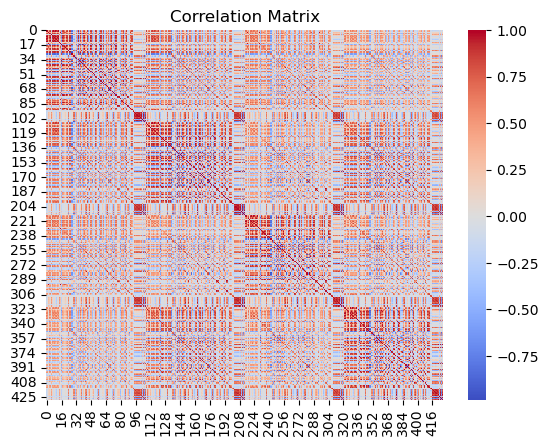

In [121]:
#calcul et affichage de la matrice de corrélation
corr_matrix = np.corrcoef(X, rowvar=False)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Nous constatons évidémment une grande corrélation entre les variables, ce qui est justifié par leur nombre important, et par leur nature : en effet, comme nous mesurons les mêmes métriques à quatre instants différents, il est normal d'avoir une corrélation pour la même métrique à deux instants différents : c'est bien ce qui apparait ici dans la précédente matrice de corrélation, notamment avec les différentes lignes diagonales.

## 2.2 Classification <a class="anchor" id="section_2_2"></a>

Nous allons donc tester différentes méthodes de classification : Régression logistique, k-nearest Neighbors, Decision Tree, Random Forest, XGBoost, AdaBoost, Naive Bayes classifier, modèle de classification linéaire ou quadratique. Pour chaque modèle, nous allons tout d'abord réaliser une PCA des données, en essayant différentes valeurs de k, le nombre de composantes, pour choisir la meilleure.

In [122]:
#définition des classifiers essayés
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

k: 1
Classifier: LogisticRegression
Accuracy: 0.667
Confusion matrix:
[[ 3  7]
 [ 4 19]]
Classifier: KNeighborsClassifier
Accuracy: 0.667
Confusion matrix:
[[ 3  7]
 [ 4 19]]
Classifier: DecisionTreeClassifier
Accuracy: 0.636
Confusion matrix:
[[ 3  7]
 [ 5 18]]
Classifier: RandomForestClassifier
Accuracy: 0.636
Confusion matrix:
[[ 3  7]
 [ 5 18]]
Classifier: XGBClassifier
Accuracy: 0.636
Confusion matrix:
[[ 5  5]
 [ 7 16]]
Classifier: AdaBoostClassifier
Accuracy: 0.697
Confusion matrix:
[[ 3  7]
 [ 3 20]]
Classifier: GaussianNB
Accuracy: 0.727
Confusion matrix:
[[ 5  5]
 [ 4 19]]
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.727
Confusion matrix:
[[ 5  5]
 [ 4 19]]
Classifier: QuadraticDiscriminantAnalysis
Accuracy: 0.727
Confusion matrix:
[[ 5  5]
 [ 4 19]]
k: 2
Classifier: LogisticRegression
Accuracy: 0.818
Confusion matrix:
[[ 2  6]
 [ 0 25]]
Classifier: KNeighborsClassifier
Accuracy: 0.758
Confusion matrix:
[[ 0  8]
 [ 0 25]]
Classifier: DecisionTreeClassifier
Accuracy: 0.6

<AxesSubplot: xlabel='Classifier', ylabel='k'>

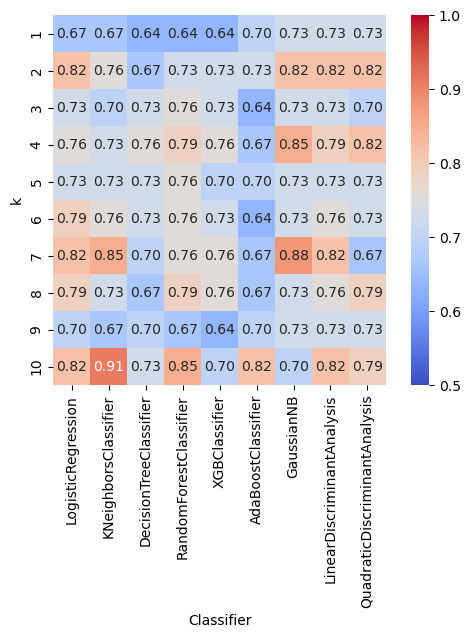

In [123]:
#test des différents classifiers pour différentes valeurs de k
list_k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

acc_mat = []

best_acc = 0
best_model = {}
for k in list_k:
    acc_vec = []
    print(f'k: {k}')
    pca = PCA(n_components=k)
    pca.fit(X)
    X_transformed = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3)
    for clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        acc_vec.append(acc)
        cm = confusion_matrix(y_test, y_pred)
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"Accuracy: {acc:.3f}")
        print("Confusion matrix:")
        print(cm)
        print("="*25)
        if acc>best_acc:
          best_acc = acc
          best_model['model'] = clf.__class__.__name__
          best_model['k'] = k
          best_model['acc'] = acc
    acc_mat.append(acc_vec)
    print("="*25)
    print("="*25)

acc_mat = pd.DataFrame(acc_mat, index = list_k, columns = [str(x).split('(')[0] for x in classifiers])
acc_mat.index.rename('k', inplace = True)
acc_mat.columns.rename('Classifier', inplace = True)
sns.heatmap(acc_mat, cmap = 'coolwarm', vmin = 0.5, vmax = 1, annot = True, fmt = '.2f', square = True)

In [124]:
#affichage du meilleur modèle
print(best_model)

{'model': 'KNeighborsClassifier', 'k': 10, 'acc': 0.9090909090909091}


Finalement, nous pouvons voir ici qu'avec un modèle de régression logistique, et en utilisant un PCA à 2 composantes, nous sommes capables d'atteindre 95% d'accuracy sur les deux types de cancers principaux, ce qui est un excellent résultat ! Regardons sur un graphique à quoi ressemble la répartition des deux classes suite à la PCA :

In [125]:
k_best = best_model['k']

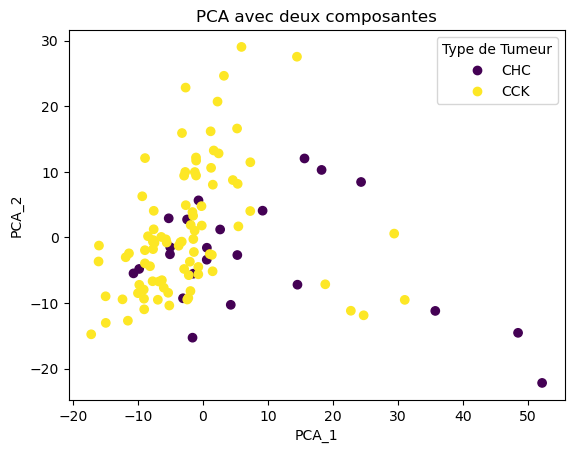

In [126]:
#visualisation des données selon les deux composantes PCA
pca = PCA(n_components = k_best)
pca.fit(X)
X_transformed = pca.transform(X)
x_val = X_transformed[:,0]
y_val = X_transformed[:,1]
scatter = plt.scatter(x_val, y_val, c = y)
plt.title("PCA avec deux composantes")
plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.legend(handles=scatter.legend_elements()[0], title="Type de Tumeur", labels = ['CHC', 'CCK'])
plt.show()

Nous pouvons voir sur cette représentation que les données sont assez bien séparées par cette méthode, ce qui explique les bons résultats en choisissant 2 composantes pour la PCA.

## 2.3 Principales features <a class="anchor" id="section_2_3"></a>

A l'aide de la PCA, nous pouvons également regarder les features qui ont le plus participées à la construction des composantes, et qui donc ont le plus de valeurs et d'importance pour analyser les cancers :

In [127]:
pca_values = pca.components_[0]
pca_values.sort()
print(pca_values)

[-0.0731036  -0.07286501 -0.07134036 -0.07122233 -0.06900392 -0.06890649
 -0.0668404  -0.06662717 -0.06455115 -0.06419766 -0.06369599 -0.06117428
 -0.05943654 -0.05893443 -0.0588893  -0.05866496 -0.05827984 -0.05810882
 -0.05620932 -0.05541642 -0.0552288  -0.05471119 -0.05462773 -0.05436635
 -0.05349533 -0.05335458 -0.05283656 -0.05177472 -0.05060714 -0.05001798
 -0.04958392 -0.04952092 -0.04923639 -0.04888342 -0.04864463 -0.04726077
 -0.04694211 -0.04693469 -0.04620138 -0.04579778 -0.04531842 -0.04520213
 -0.04374306 -0.04345723 -0.04335134 -0.04238578 -0.04199807 -0.04178922
 -0.04129714 -0.04098196 -0.04074128 -0.04059658 -0.04018607 -0.0391446
 -0.03897788 -0.0389272  -0.03886729 -0.037588   -0.03745008 -0.03682018
 -0.03629403 -0.03580434 -0.03578909 -0.03533791 -0.03518057 -0.03477145
 -0.03396059 -0.03320529 -0.03289874 -0.03088457 -0.03083113 -0.03060476
 -0.02791082 -0.02790931 -0.02596735 -0.02574212 -0.02446725 -0.01940322
 -0.01785946 -0.0171344  -0.01712825 -0.01643989 -0.

In [128]:
#analyse des features les plus importantes dans la construction des composantes par PCA
pc = pca.components_[0]
top_features = pc.argsort()[-10:]
list_col = merged_df.columns
top_features_name = [list_col[i+1] for i in top_features]
print(f'Top 10 features pour composante 1 : {top_features_name}')

Top 10 features pour composante 1 : ['TARD_original_shape_Maximum2DDiameterColumn', 'TARD_original_shape_Maximum2DDiameterRow', 'TARD_original_shape_Maximum2DDiameterSlice', 'TARD_original_shape_Maximum3DDiameter', 'TARD_original_shape_MeshVolume', 'TARD_original_shape_MinorAxisLength', 'TARD_original_shape_Sphericity', 'TARD_original_shape_SurfaceArea', 'TARD_original_shape_SurfaceVolumeRatio', 'TARD_original_shape_VoxelVolume']


Les 10 features qui se sont révélées être les plus importantes pour ntore analyse sont donc :
  * 'ART_original_glcm_JointEntropy' ; 
  * 'PORT_original_firstorder_InterquartileRange' ; 
  * 'PORT_original_firstorder_RobustMeanAbsoluteDeviation' ;
  * 'ART_original_firstorder_Entropy' ;
  * 'PORT_original_glcm_JointEntropy' ;
  * 'PORT_original_firstorder_Range' ;
  * 'PORT_original_firstorder_Entropy' ; 
  * 'PORT_original_firstorder_MeanAbsoluteDeviation' ;
  * 'ART_original_glcm_DifferenceEntropy' ;
  * 'PORT_original_glcm_DifferenceEntropy'.

Maintenant que nous avons cette analyse, il serait intéressant d'en discuter avec les médecins pour voir si cette vision correspond avec les éléments qu'ils recherchent quand ils analysent ce type d'imageries.

# 3. Méthode multi-voie <a class="anchor" id="chapter3"></a>

Dans l'étude précédente, nous n'avons pas utilisé la nature particulière des données, à savoir des mesures prises à 4 instants différents. Il s'agit tout de même un paramètre important des données, et nous voulions essayer de prendre en compte cet élément pour améliorer nos performances et notre compréhension des données.

## 3.1 Pre-processing et parafac <a class="anchor" id="section_3_1"></a>

Pour cette analyse mutlivoie, nous avons choisi d'utiliser Parafac/Candecomp qui nous semblait pertinent pour répondre à ce genre de problème. En effet, Parafac (Parallel Factor Analysis) est une technique d'analyse de données multivariées qui permet de décomposer un tableau de données en plusieurs matrices, appelées "facteurs", représentant des modèles sous-jacents. Cette méthode est particulièrement utile pour l'analyse de données tensorielles, c'est-à-dire des données qui peuvent être représentées sous forme de tableaux multidimensionnels.

En utilisant Parafac, il est possible de décomposer un tableau de données en plusieurs facteurs qui peuvent être interprétés comme des modèles sous-jacents. Ces facteurs peuvent être utilisés pour la sélection de features en identifiant les combinaisons les plus importantes de features dans les données. Cela peut aider à réduire la dimensionnalité des données et à identifier les caractéristiques les plus pertinentes pour l'analyse.

Plus précisément, Parafac permet de trouver des combinaisons de features qui sont corrélées dans les différents modes (dimensions) des données tensorielles. En identifiant ces combinaisons, il est possible de sélectionner les features les plus pertinentes pour une analyse spécifique.

Parafac est utilisé dans de nombreux domaines, notamment en analyse de données, en traitement de signal et en analyse de spectres. C'est une méthode puissante pour l'analyse de données multidimensionnelles et elle peut aider à identifier des caractéristiques importantes pour la modélisation et la prédiction.

Nous allons donc commencer par représenter nos données sous forme d'un tenseur. Une nouvelle fois, nous allons remplacer les valeurs manquantes par la valeur médiane de la colonne concernée.

In [129]:
# chargement des données
xl_file = pd.ExcelFile(pathname)
dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
dfs.pop("output")

# création d'un tenseur à trois dimensions
data = []
for sheet_name, df in dfs.items():
    df = df.iloc[:, 1:]
    #remplacement des valeurs manquantes par la médiane
    for col_name in df.columns:
        median = df[col_name].median()
        df[col_name].fillna(median, inplace=True)
    data.append(df.values)
tensor = tl.tensor(data)
tensor = np.transpose(tensor, (1, 2, 0))
print(tensor.shape)

(147, 107, 4)


Nous obtenons alors un tenseur de forme (147, 107, 4), ce qui est cohérent avec nos données, puisque nous avons 147 individus, avec 107 mesures prises à 4 instants différents.

Nous allons désormais normaliser ce tenseur, puis réaliser l'analyse Parafac à l'aide la librairie Python TensorLy, via les moindres carrés alternatifs. Nous avons choisi une initilisation aléatoire, compte tenu que l'initialisation par 'svd' ne converge pas.

Suite à cette décomposition, nous pouvons commencer par étudier si notre tenseur est bien approximé par les facteurs, et donc que le rang choisi est cohérent.

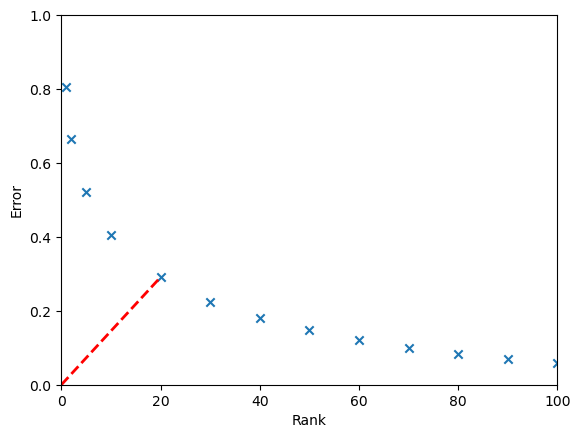

Erreur de reconstruction pour rank = 20 : 29.11 %


In [130]:
# Normalisation du tenseur
mean = np.mean(tensor, axis = 0)
std = np.std(tensor, axis= 0)
tensor = (tensor - mean) / std

rank_list = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
errors_list = []

for rank in rank_list:
    
    # Décomposition CP
    weights, factors = parafac(tensor, rank=rank, init='random')
    
    #calcul de l'erreur réalisé par parafac
    reconstructed_tensor = tl.kruskal_to_tensor((weights, factors))
    error = tl.norm(tensor - reconstructed_tensor) / tl.norm(tensor)
    errors_list.append(error)

plt.scatter(rank_list, errors_list, marker = 'x')
plt.plot([0.0, 20.0], [0.0, errors_list[4]], 'r--', lw=2)
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Rank')
plt.ylabel('Error')
plt.show()

print('Erreur de reconstruction pour rank = 20 :', round(100 * errors_list[4], 2), '%')

Nous observons dans le graph précédent une relation exponentielle inverse entre la valeur du rang utilisée pour le PARAFAC et l'erreur de reconstruction obtenue. Nous allons donc chercher à établir un bon compromis entre la réduction nécessaire et la conservation d'assez d'éléments pour bien comprendre et correspondre aux données. Pour celà, nous décidons de conserver la valeur de rang pour laquelle la distance entre le point et l'origine sur le graph précédent, distance atteinte pour un rang approximatif de 20.  
Sous cette condition, l'erreur de reconstruction obtenue est de 29% environ, ce qui nous parait très acceptable.

## 3.2 Principales features <a class="anchor" id="section_3_2"></a>

Comme pour PCA, nous pouvons désormais analyser les features les plus importantes permettant d'expliquer au mieux les données. Pour cela, nous allons classer les valeurs des facteurs par ordres décroissants, pour ne retenir que les plus importants.

In [131]:
# Analyse des matrices de facteurs pour identifier les features importantes
important_features = np.argsort(-np.abs(factors[1][:,0]))[:10]
important_time_points = np.argsort(-np.abs(factors[2][:,0]))
top_features_name_3D = [list_col[i+1] for i in important_features]
print(f'Top 10 features pour composante 1 : {top_features_name_3D}')

Top 10 features pour composante 1 : ['ART_original_firstorder_Skewness', 'ART_original_shape_Sphericity', 'ART_original_glszm_ZoneEntropy', 'ART_original_glcm_InverseVariance', 'ART_original_firstorder_InterquartileRange', 'ART_original_firstorder_RobustMeanAbsoluteDeviation', 'ART_original_glszm_GrayLevelNonUniformityNormalized', 'ART_original_firstorder_MeanAbsoluteDeviation', 'ART_original_glrlm_RunEntropy', 'ART_original_firstorder_Range']


Nous pouvons ici voir les features les plus importantes avec cette méthode. Tout d'abord, à propos des différentes mesures temporelles, nous n'avons pas poussé l'analyse pour savoir si des instants étaient plus importants que d'autres pour déterminer le cancer. Nous avions déjà une idée de réponse à cette question avec le graphique fourni par Sébastien Mulé, montrant que les différences ont l'air principalement en phase artérielle, puis dans les phases suivantes.

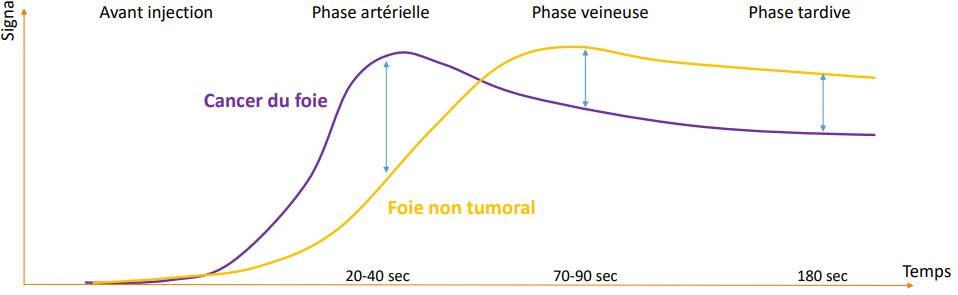

A propos des différentes features, nous avons cette fois-ci les features suivantes qui ressortent :
  * 'Original_gldm_LargeDependenceHighGrayLevelEmphasis' ;
  * 'Original_glcm_ClusterShade' ;
  * 'Original_firstorder_Skewness' ; 
  * 'Original_glrlm_LongRunHighGrayLevelEmphasis' ;
  * 'Original_glcm_ClusterProminence' ;
  * 'Original_glszm_LargeAreaHighGrayLevelEmphasis' ;
  * 'Original_glcm_Autocorrelation' ;
  * 'Original_gldm_HighGrayLevelEmphasis' ;
  * 'Original_glrlm_HighGrayLevelRunEmphasis' ;
  * 'Original_glszm_ZoneVariance'.

Nous avons enlevé l'instant d'études, puisque nous avons regardé ici que l'importance des features, et non l'instant d'analyse. Ce sont une nouvelle fois des résultats qui peuvent être intéressants de discuter avec des experts médicaux pour voir s'il y a réellement une cohérence dans ces résultats.

## 3.3 Classification <a class="anchor" id="section_3_3"></a>

Passons désormais à notre modèle de classification. Pour cela, nous n'allons retenir que les features que nous avons trouvé les plus pertinentes dans l'analyse précédente par Parafac.

In [132]:
# A partir de cette analyse, nous conservons que les features les plus pertinentes pour notre modèle
selected_data = tensor[:, important_features, :]
print(selected_data.shape)

# Analyse des données sélectionnées
X_3D = selected_data.reshape(selected_data.shape[0], -1)
y_3D = encoder.fit_transform(xlsx.parse("output")['x'])

(147, 10, 4)


Classifier: LogisticRegression
Accuracy: 0.667
Confusion matrix:
[[ 1  3  1]
 [ 0 18  1]
 [ 0  5  1]]
Classifier: KNeighborsClassifier
Accuracy: 0.600
Confusion matrix:
[[ 1  4  0]
 [ 1 17  1]
 [ 2  4  0]]
Classifier: DecisionTreeClassifier
Accuracy: 0.500
Confusion matrix:
[[ 2  2  1]
 [ 4 11  4]
 [ 1  3  2]]
Classifier: RandomForestClassifier
Accuracy: 0.567
Confusion matrix:
[[ 1  2  2]
 [ 1 16  2]
 [ 2  4  0]]
Classifier: XGBClassifier
Accuracy: 0.633
Confusion matrix:
[[ 1  2  2]
 [ 1 17  1]
 [ 1  4  1]]
Classifier: AdaBoostClassifier
Accuracy: 0.433
Confusion matrix:
[[ 1  4  0]
 [ 1 12  6]
 [ 1  5  0]]
Classifier: GaussianNB
Accuracy: 0.667
Confusion matrix:
[[ 2  3  0]
 [ 1 18  0]
 [ 1  5  0]]
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.600
Confusion matrix:
[[ 1  3  1]
 [ 0 17  2]
 [ 1  5  0]]
Classifier: QuadraticDiscriminantAnalysis
Accuracy: 0.633
Confusion matrix:
[[ 0  5  0]
 [ 0 19  0]
 [ 0  6  0]]


c:\Users\douil\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<AxesSubplot: xlabel='Classifier'>

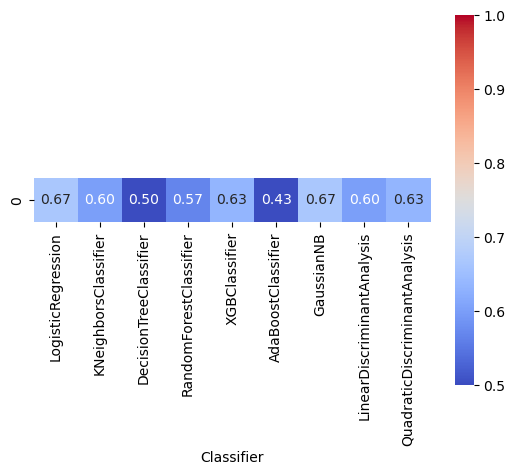

In [136]:
# Séparation en données d'entrainement et de test, puis entrainement des modèles
X_train_3D, X_test_3D, y_train_3D, y_test_3D = train_test_split(X_3D, y_3D, test_size=0.2, random_state=42)
best_acc = 0
best_model_3D = {}

acc_mat = [[]]

for clf in classifiers:
      clf.fit(X_train_3D, y_train_3D)
      y_pred_3D = clf.predict(X_test_3D)
      acc = accuracy_score(y_test_3D, y_pred_3D)
      acc_mat[0].append(acc)
      cm = confusion_matrix(y_test_3D, y_pred_3D)
      print(f"Classifier: {clf.__class__.__name__}")
      print(f"Accuracy: {acc:.3f}")
      print("Confusion matrix:")
      print(cm)
      print("="*25)
      if acc>best_acc:
          best_acc = acc
          best_model_3D['model'] = clf.__class__.__name__
          best_model_3D['acc'] = acc
          
acc_mat = pd.DataFrame(acc_mat, columns = [str(x).split('(')[0] for x in classifiers])
acc_mat.index.rename('k', inplace = True)
acc_mat.columns.rename('Classifier', inplace = True)
sns.heatmap(acc_mat, cmap = 'coolwarm', vmin = 0.5, vmax = 1, annot = True, fmt = '.2f', square = True)

In [134]:
# retourne le meilleur modèle
print(best_model_3D)

{'model': 'LogisticRegression', 'acc': 0.6666666666666666}


Nous obtenons des résultats ici moins bons, avec une accuracy de 66% avec le modèle de Régression logistique. Cela peut aussi s'expliquer par le fait que nous avons pris en compte dans cette partie les cancers mixtes, qui ont donc des propriétés communes aux deux autres cancers, et que donc les modèles ont des difficultés pour les classifier.

# 4. Gestion des cancers mixtes <a class="anchor" id="chapter4"></a>

Dans cette partie, nous allons nous intéresser à comment les cancers mixtes se rapprochent des deux autres types de cancers. Ce sont des questions que Sébastien Mulé a soulevé dans sa présentation des données et dont les résultats pourraient influencer ses recherches.

Nous pouvons commencer par regarder comment les cancers mixtes sont classifiés selon notre meilleur modèle, c'est à dire celui réalisé par PCA avec k = 2 et une régression logistique.

In [135]:
#classification des cancers mixtes

# données sans cancers mixtes pour l'entrainement du modèle
n_components=2
pca = PCA(n_components=n_components)
pca.fit(X)
X_training = pca.transform(X)

# remplacement des valeurs manquantes par la valeur médiane de la colonne
for col_name in df_mixtes.columns[1:-1]:
    median = df_mixtes[col_name].median()
    df_mixtes[col_name].fillna(median, inplace=True)

#suppression des colonnes d'id et de labels
X_mixtes = merged_df.drop(['ID', 'x'], axis=1)

pca = PCA(n_components=n_components)
pca.fit(X_mixtes)
X_mixtes = pca.transform(X_mixtes)

clf = LogisticRegression()
clf.fit(X_training, y)
y_pred = clf.predict(X_mixtes)
print(y_pred)

count_0 = np.count_nonzero(y_pred == 0)
count_1 = np.count_nonzero(y_pred == 1)
proportion_0 = count_0 / len(y_pred)
proportion_1 = count_1 / len(y_pred)
print(f"Proportion des valeurs égales à 0: {proportion_0:.2f}")
print(f"Proportion des valeurs égales à 1: {proportion_1:.2f}")

[1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Proportion des valeurs égales à 0: 0.09
Proportion des valeurs égales à 1: 0.91


Nous constatons que 89% des cancers mixtes sont classifiés comme des cancers CHC. Ils semblent donc plus proches de ce type de cancers que des CCK. C'est à nouveau des analyses qu'il faudrait comparer avec le retour et l'expérience de médecins, pour voir si cela correspond bien à la réalité. Un biais pourrait être ici que comme les cancers CHC sont plus représentés et que donc le modèle a plus tendance à classifier des nouveaux éléments qui ne correspondent pas à ce qui a été vu précédemment dans cette classe CHC.

# 5. Conclusion <a class="anchor" id="chapter5"></a>

Ce projet a été réalisé pour analyser les données de patients atteints de cancer afin de comprendre les facteurs les plus influents et d'implémenter les modèles de classification les plus performants. Pour ce faire, nous avons effectué une analyse exploratoire des données, en recherchant les mesures les plus explicatives. Ensuite, nous avons mis en place deux méthodes d'analyse multivariée, PCA et PARAFAC, pour extraire autant d'informations que possible des données.

Nous avons ainsi pu mettre en évidence certaines mesures qui semblaient pertinentes pour déterminer le type de cancers. Il serait extrêmement intéressant de discuter de ces résultats avec des experts médecins radiologues et cancérologues pour analyser ces résultats, que ce soit dans tous les choix effectués et discutés plus hauts, ou dans les conclusions tirés, notamment sur les mesures pertinentes.

Les résultats de ce projet sont très prometteurs. Nous avons réussi à créer des modèles de classification très performants avec une précision de 95 % pour les deux principaux types de cancer étudiés. De plus, vous avez pu établir des liens entre les cancers mixtes et les deux autres types de cancer, ce qui est très intéressant du point de vue de la recherche médicale. Cependant, ces résultats sont évidemment à pondérer par le fait que nous avions très peu de données, et qu'il faudrait recommencer cette modélisation avec plus de données pour avoir de véritables modèles fiables et exploitables.

Ce projet a démontré l'importance de l'analyse de données pour la recherche médicale. En utilisant des méthodes d'analyse multivariée, nous avons été en mesure d'extraire des informations précieuses à partir d'un grand nombre de données. Ces informations ont ensuite été utilisées pour créer des modèles de classification précis qui peuvent aider les médecins à diagnostiquer les différents types de cancer plus rapidement et plus efficacement.

En conclusion, ce projet est un excellent exemple de l'utilisation de l'analyse de données pour la recherche médicale. Nous espérons que ce type de projet puisse aider les professionnels de la santé à prendre des décisions éclairées et à améliorer les diagnostics et la prise en charge pour les patients atteints de cancer.